# Perform one sample test in control cells

Both HBECs and PBMCs

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/main/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [4]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [5]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [6]:
adata.shape

(69958, 36588)

### Setup memento

In [7]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [8]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [9]:
memento.setup_memento(adata, q_column='q')

In [10]:
adata.obs.head(3)

,NUM.SNPS,BEST.GUESS,DROPLET.TYPE,batch,HTO_classification,condition,donor,stim,time,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,q,memento_size_factor
AAACCCAAGGAAGTAG-1,1700,donor0,SNG,0,hash-10,d2513_lambda_9,d2513,lambda,9,4297,4297,12191.0,1394.0,11.434665,3,ciliated,0.10425,0.955289
AAACCCAAGGGACTGT-1,839,donor0,SNG,0,hash-3,d2513_alpha_24,d2513,alpha,24,2171,2171,7270.0,386.0,5.309491,5,bc,0.10425,0.824407
AAACCCACAATCTGCA-1,1130,donor1,SNG,0,hash-1,d2614_alpha_3,d2614,alpha,3,3016,3016,9544.0,516.0,5.406538,0,basal,0.10425,0.988939


In [11]:
adata.uns['memento'].keys()

dict_keys(['q_column', 'all_q', 'estimator_type', 'filter_mean_thresh', 'num_bins', 'least_variable_genes', 'all_1d_moments'])

### Perform one sample test on ciliated, control cells

In [12]:
adata_ctrl = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control']), :].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [13]:
memento.create_groups(adata_ctrl, label_columns=['donor'])

In [14]:
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)

In [15]:
memento.ht_1d_moments(
    adata_ctrl,
    formula_like='1',
    cov_column='Inter',
    num_boot=10000, 
    verbose=1,
    num_cpus=13)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    3.4s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    8.3s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   16.9s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   28.5s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   42.9s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  1.0min
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.2min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.8min
[Parallel(n_jobs=13)]: Done 6024 tasks      | elapsed:  3.3min
[Parallel(n_jobs=13)]: Done 7174 tasks      | elapsed:  4.0min
[Parallel(n_jobs=13)]: Done 8424 tasks      | elapsed:  4.7min
[Parallel(n_jobs=13)]: Done 9774 tasks      | elapsed:  5.4min
[Parallel(n_jobs=13)]: Done 10150 out of 1015

In [16]:
onesamp_ht_df = memento.get_1d_ht_result(adata_ctrl)

In [17]:
onesamp_ht_df['dv_fdr'] = memento.util._fdrcorrect(onesamp_ht_df['dv_pval'])

In [18]:
hv_genes = onesamp_ht_df.query('dv_fdr < 0.001 & dv_coef > 0').gene.tolist()
lv_genes = onesamp_ht_df.query('dv_fdr < 0.001 & dv_coef < 0').gene.tolist()

In [19]:
# for gene in hv_genes:
#     print(gene)

In [20]:
onesamp_ht_df.query('gene.str.contains("IFIT")', engine='python')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
5204,IFIT2,-0.469849,0.125733,5.932661e-04,2.978472,0.266980,3.543171e-06,0.000251
5205,IFIT3,-0.020981,0.074757,7.768223e-01,2.309936,0.226460,1.202212e-07,0.000076
5206,IFIT1,0.274242,0.062030,2.222627e-04,1.955586,0.148595,2.524694e-06,0.000199
5207,IFIT5,-1.348701,0.077997,1.965194e-07,0.078432,0.445955,8.385161e-01,0.933849
5386,IFITM2,-0.005149,0.063042,9.355064e-01,1.715650,0.196241,3.081195e-06,0.000227
5387,IFITM1,-0.627829,0.081380,3.896858e-04,2.059088,0.224589,6.795485e-06,0.000381
5388,IFITM3,1.395832,0.039103,3.934385e-05,1.245325,0.166377,4.229240e-05,0.001314
5419,IFITM10,-0.080528,0.050779,1.144886e-01,0.986147,0.133937,1.332318e-05,0.000581


In [25]:
onesamp_ht_df.sort_values('dv_coef', ascending=False).head()

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
9347,BPIFA1,1.711823,0.239303,0.000024,4.772759,0.171150,6.676774e-06,0.000378
5086,MSMB,2.002644,0.235118,0.000016,4.753874,0.318499,6.612524e-07,0.000114
1640,CCL20,-0.122780,0.209372,0.554445,4.453336,0.174828,5.973438e-07,0.000108
5618,SCGB1A1,1.821146,0.175603,0.000003,4.449934,0.141542,3.148436e-08,0.000036
9591,TFF3,1.162709,0.202107,0.000059,4.414665,0.411661,7.066126e-07,0.000116


In [24]:
hbec_1d = onesamp_ht_df[['gene', 'dv_coef']].copy()

In [20]:
with open('hv_genes.pkl', 'wb') as f:
    pkl.dump(hv_genes, f)

### Mean vs variability plots for ctrl cells

In [43]:
m_df, v_df = memento.get_1d_moments(adata_ctrl, groupby='ALL')

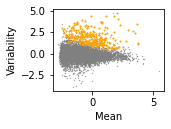

In [45]:
plt.figure(figsize=(2, 1.5))
plt.scatter(m_df['ALL_sg'], v_df['ALL_sg'], s=0.1,color='gray')
plt.scatter(m_df.query('gene in @hv_genes')['ALL_sg'], v_df.query('gene in @hv_genes')['ALL_sg'], s=1,color='orange')
plt.xlabel('Mean'); plt.ylabel('Variability');
plt.savefig(fig_path + 'm_vs_v_onesamp.png', bbox_inches='tight', dpi=300)


### Check the result in PBMCs

In [26]:
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/supp/'
data_path = '/data_volume/parameter_estimation/'

#### Read PBMC dataset and setup memento

In [27]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [28]:
def simplify_name(name):
    return name.split('.')[0]

In [29]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')

In [30]:
adata.obs['q'] = 0.07

In [31]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

#### Isolate the control cells and perform one sample test

In [32]:
adata_ctrl = adata.copy()[(adata.obs['cell']=='CD14+ Monocytes') & (adata.obs['stim']=='stim')].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [33]:
adata_ctrl.obs.head(2)

,tsne1,tsne2,ind,stim,cluster,cell,multiplets,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,cell_type,q,memento_size_factor
index,,,,,,,,,,,,,,,,,,,,
AAACATACGCGAAG-1,3.550854,35.214427,101,stim,8,CD14+ Monocytes,singlet,1319,7.185387,5312.0,8.577912,0.0,0.0,0.0,0.0,0.0,0.0,CD14+ Monocytes - stim,0.07,1.528051
AAACATACTCAGGT-1,6.290151,26.974231,1016,stim,8,CD14+ Monocytes,singlet,563,6.335054,2152.0,7.674617,0.0,0.0,0.0,0.0,0.0,0.0,CD14+ Monocytes - stim,0.07,0.912694


In [34]:
memento.create_groups(adata_ctrl, label_columns=['ind'])

In [35]:
memento.compute_1d_moments(adata_ctrl, min_perc_group=.7)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log


In [36]:
memento.ht_1d_moments(
    adata_ctrl,
    formula_like='1',
    cov_column='Inter',
    num_boot=10000, 
    verbose=1,
    num_cpus=13)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    3.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:   13.7s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   28.3s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   50.1s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 1938 out of 1938 | elapsed:  2.0min finished


In [37]:
onesamp_ht_df = memento.get_1d_ht_result(adata_ctrl)

In [38]:
onesamp_ht_df['dv_fdr'] = memento.util._fdrcorrect(onesamp_ht_df['dv_pval'])

In [39]:
hv_genes = onesamp_ht_df.query('dv_fdr < 0.001 & dv_coef > 0').gene.tolist()
lv_genes = onesamp_ht_df.query('dv_fdr < 0.001 & dv_coef < 0').gene.tolist()

In [65]:
for gene in hv_genes:
    print(gene)

HES4
FUCA1
MARCKSL1
PRDX1
GBP1
RPL5
C1orf162
S100A9
S100A8
S100A4
LMNA
FCGR3A
GLUL
IL10
CYP1B1
ZFP36L2
PLEK
VAMP5
GNLY
IL1R2
IL1B
IL1RN
CXCR4
TNFAIP6
HSPE1
PTMA
MANF
TNFSF10
IL8
PPBP
CXCL3
CXCL2
CXCL9
CXCL10
CXCL11
PLAC8
SLC39A8
RP11-701P16.5
IL7R
GLRX
CD14
CD74
DUSP1
SERPINB1
CD83
HSPA1A
HSPA1B
HLA-DRA
HLA-DRB1
HLA-DQA1
HLA-DPA1
HLA-DPB1
RPL10A
HSP90AB1
PLA2G7
PNRC1
FAM26F
SOD2
ACTB
RALA
HSPB1
FGL2
CD36
GIMAP7
INSIG1
TMSB4X
SAT1
TIMP1
DEFB1
CTSB
IDO1
FABP5
CA2
RPS6
ANXA1
CTSL
TXN
HSPA5
CREM
PPIF
ANKRD22
IFIT2
IFIT1
BLOC1S2
CTSD
HBB
MS4A6A
MS4A4A
MS4A7
CTSC
HSPA8
CLEC4E
CLEC2D
CLEC2B
ARHGDIB
LYZ
PHLDA1
BTG1
HSP90B1
SDS
DYNLL1
HSPH1
CCNA1
LPAR6
RCBTB2
GPR183
NFKBIA
CALM1
LGMN
IFI27
HSP90AA1
THBS1
PDIA3
SOCS1
IGSF6
NUPR1
MT2A
HERPUD1
CCL2
CCL7
CCL8
CCL5
CCL3
CCL4
CCL3L1
CCR7
ACTG1
SERPINB2
MAFB
ADA
ZFAS1
CEBPB
ACP5
ZFP36
C5AR1
IL4I1
LILRA3
HMOX1
LGALS2
RPL3
CSTB


In [41]:
m_df, v_df = memento.get_1d_moments(adata_ctrl, groupby='ALL')

In [64]:
onesamp_ht_df.query('dv_fdr < 0.001')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
0,HES4,0.080432,0.029680,7.799220e-03,0.992417,0.076778,1.513364e-06,0.000049
1,ISG15,4.796939,0.009312,1.156650e-10,-0.535670,0.034061,1.557343e-06,0.000049
27,FUCA1,-1.501005,0.067548,1.932027e-07,1.608537,0.149049,4.916403e-07,0.000027
49,MARCKSL1,-0.036962,0.030802,2.309769e-01,0.818790,0.092809,1.266782e-05,0.000208
73,PRDX1,0.376804,0.022114,1.228999e-06,0.329799,0.068934,9.248770e-05,0.000985
...,...,...,...,...,...,...,...,...
1886,HMOX1,-0.156773,0.037328,2.578461e-04,1.463340,0.081467,4.801457e-07,0.000027
1891,LGALS2,-1.435091,0.071062,1.656105e-07,0.828509,0.120414,1.030651e-05,0.000188
1896,RPL3,0.812561,0.022236,4.342648e-05,0.765117,0.065757,1.659497e-05,0.000257
1911,TYMP,2.418767,0.010003,9.456608e-07,-0.492264,0.046111,1.726018e-05,0.000259


In [42]:
pbmc_1d = onesamp_ht_df[['gene', 'dv_coef', 'dv_fdr']].copy()

In [45]:
joined = pbmc_1d.merge(hbec_1d, on='gene', suffixes=('_pbmc', '_hbec'))

In [58]:
stats.pearsonr(joined['dv_coef_pbmc'], joined['dv_coef_hbec'])

(0.3386708837306288, 1.9589171103078664e-43)

In [59]:
joined.query('gene == "BPIFA1"')

,gene,dv_coef_pbmc,dv_coef_hbec,diff


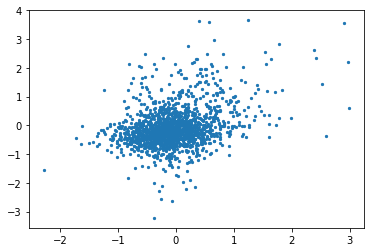

In [50]:
plt.scatter(joined['dv_coef_pbmc'], joined['dv_coef_hbec'], s=5)

In [52]:
joined['diff'] = (joined['dv_coef_pbmc']-joined['dv_coef_hbec']).abs()

In [62]:
joined.query('gene.str.contains("IFIT")', engine='python')

,gene,dv_coef_pbmc,dv_coef_hbec,diff
866,IFIT2,0.664085,2.978472,2.314387
867,IFIT3,0.343397,2.309936,1.966539
868,IFIT1,0.424394,1.955586,1.531192
869,IFIT5,0.025312,0.078432,0.053120
885,IFITM2,-0.423400,1.715650,2.139050
886,IFITM1,-0.647516,2.059088,2.706604
887,IFITM3,-1.239418,1.245325,2.484743


In [61]:
joined.sort_values('diff', ascending=False).head(30)

,gene,dv_coef_pbmc,dv_coef_hbec,diff
1174,C15orf48,0.401876,3.648941,3.247066
1030,LYZ,0.571003,3.591128,3.020125
1,ISG15,-0.535670,2.482467,3.018137
1207,ISG20,-0.807819,2.138514,2.946332
416,PLAC8,2.587580,-0.353157,2.940737
773,GSDMD,-0.372895,-3.221130,2.848235
886,IFITM1,-0.647516,2.059088,2.706604
1562,MX2,-0.609975,2.048708,2.658683
1552,BTG3,-0.233927,2.359474,2.593401
1560,MORC3,-0.062778,-2.626932,2.564154


In [57]:
hbec_1d.sort_values('dv_coef', ascending=False).head(20)

,gene,dv_coef
9347,BPIFA1,4.772759
5086,MSMB,4.753874
1640,CCL20,4.453336
5618,SCGB1A1,4.449934
9591,TFF3,4.414665
9348,BPIFB1,4.029002
2800,CDC20B,3.995393
5416,MUC5B,3.798337
6281,TSPAN8,3.763758
2802,CCNO,3.682878


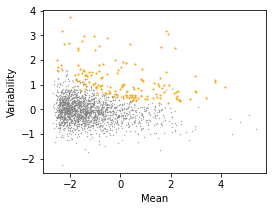

In [38]:
plt.figure(figsize=(4, 3))
plt.scatter(m_df['ALL_sg'], v_df['ALL_sg'], s=0.1,color='gray')
plt.scatter(m_df.query('gene in @hv_genes')['ALL_sg'], v_df.query('gene in @hv_genes')['ALL_sg'], s=1,color='orange')
plt.xlabel('Mean'); plt.ylabel('Variability');
plt.savefig(fig_path + 'm_vs_v_onesamp_pbmc.png', bbox_inches='tight', dpi=300)


In [36]:
onesamp_ht_df.sort_values('dv_coef', ascending=False).head(20)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
295,IL1B,-2.010218,0.200637,1.685939e-05,3.740840,0.342575,9.414523e-10,9.122672e-07
280,GNLY,-2.336887,0.178715,1.062464e-06,3.196390,0.338151,3.151618e-07,2.035945e-05
1599,CCL4,1.829208,0.060254,1.891437e-08,3.194377,0.103889,1.022157e-08,3.170909e-06
1598,CCL3,1.894398,0.051078,8.075448e-10,3.052662,0.159610,2.131682e-07,1.530074e-05
1509,NUPR1,-1.053738,0.088842,1.710292e-04,2.981152,0.126372,1.002254e-07,9.249370e-06
1102,HBB,-1.452393,0.136822,8.506516e-06,2.978186,0.420924,2.290646e-08,3.170909e-06
489,CXCL3,-0.541382,0.079517,4.171528e-04,2.900144,0.106330,6.977687e-07,3.467374e-05
1605,CCR7,-1.555124,0.093630,1.050379e-06,2.783267,0.200630,2.216089e-08,3.170909e-06
1600,CCL3L1,-2.046472,0.123018,1.458550e-06,2.684193,0.262395,6.184054e-07,3.153867e-05
487,IL8,0.399955,0.052920,5.748862e-06,2.666414,0.081006,7.954302e-08,8.113388e-06


In [29]:
onesamp_ht_df.query('gene.str.contains("IFIT")', engine='python')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
1062,IFIT2,2.123506,0.016047,2.519822e-10,0.664085,0.053250,8.676343e-06,0.000155
1063,IFIT3,2.360893,0.014359,4.376796e-06,0.343397,0.039582,9.831944e-06,0.000171
1064,IFIT1,2.250409,0.014361,1.355806e-10,0.424394,0.039500,1.182113e-05,0.000194
1065,IFIT5,-1.460855,0.051044,1.509962e-07,0.025312,0.247138,9.143086e-01,0.956234
1086,IFITM2,1.065460,0.015153,1.328423e-05,-0.423400,0.076280,8.121454e-05,0.000865
1087,IFITM1,-1.098009,0.036997,1.352632e-08,-0.647516,0.259061,3.449655e-02,0.130320
1088,IFITM3,2.743918,0.007590,1.333677e-06,-1.239418,0.054461,4.073864e-07,0.000025
